In [8]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D,MaxPooling1D, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [2]:
dataset = pd.read_csv('convertcsv.csv')
data = dataset[['text','aspectCategories/aspectCategory/0/_polarity']]
#data = dataset.rename(index=str, columns={ 0: "text", 6: "sentiment"})
newdata = data.dropna()
newdata.isnull().sum()
newdata = newdata.rename(columns={'aspectCategories/aspectCategory/0/_polarity': 'sentiment'})

In [3]:
newdata['text'] = newdata['text'].apply(lambda x: x.lower())
print(newdata[ newdata['sentiment'] == 'positive'].size)
print(newdata[ newdata['sentiment'] == 'negative'].size)
print(newdata[ newdata['sentiment'] == 'neutral'].size)
print(newdata[ newdata['sentiment'] == 'conflict'].size)
newdata = newdata[newdata.sentiment != "conflict"]
newdata = newdata[newdata.sentiment != "neutral"]
newdata.head(5)

3484
1316
954
334


,text,sentiment
0,but the staff was so horrible to us.,negative
1,"to be completely fair, the only redeeming fact...",positive
2,"the food is uniformly exceptional, with a very...",positive
3,where gabriela personaly greets you and recomm...,positive
4,"for those that go once and don't enjoy it, all...",positive


In [4]:
#Make number of classes balanced 
num_of_categories = 700
shuffled = newdata.reindex(np.random.permutation(newdata.index))
po = shuffled[shuffled['sentiment'] == 'positive'][:num_of_categories]
ng = shuffled[shuffled['sentiment'] == 'negative'][:num_of_categories]

concated = pd.concat([po,ng], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
print(concated.size)

print(concated[ concated['sentiment'] == 'positive'].size)
print(concated[ concated['sentiment'] == 'negative'].size)


2716
1400
1316


In [5]:
import spacy
nlp = spacy.load('en')

sentiment_terms = []
for review in nlp.pipe(concated['text']):
        if review.is_parsed:
            sentiment_terms.append(' '.join([token.lemma_ for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            sentiment_terms.append('')  
concated['sentiment_terms'] = sentiment_terms
concated.head(10)

,text,sentiment,sentiment_terms
383,would recommend - perfect for those looking fo...,positive,recommend perfect look close grand
28,"if it isn't for the food (a+++), it must be th...",positive,
807,our server checked on us maybe twice during th...,negative,check entire
670,i liked the beer selection!,positive,like
909,the lobster sandwich is $24 and although it wa...,negative,good warrant
1309,"the service was bad, the food took to forever ...",negative,bad take come sit upper
671,"all in all a wonderful experience, can't wait ...",positive,wonderful wait come
333,i can't wait to go back.,positive,wait
1356,the hostess is rude to the point of being offe...,negative,rude offensive
766,i ordered the crab cocktail and it was soaked ...,negative,order soak taste


In [6]:
max_fatures = 6000
MAX_SEQUENCE_LENGTH = 30
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(concated['sentiment_terms'].values)
X = tokenizer.texts_to_sequences(concated['sentiment_terms'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

import pickle

# saving
with open('review_token_cnn_lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
embedding_dim = 128

model = Sequential()
model.add(Embedding(max_fatures, embedding_dim, input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 128)           768000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
__________

In [10]:
Y = pd.get_dummies(concated['sentiment']).values
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[[0 1]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]
(1086, 30) (1086, 2)
(272, 30) (272, 2)


In [11]:
batch_size = 32
sentiment_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs = 10, batch_size=batch_size, verbose = 2)

Train on 1086 samples, validate on 272 samples
Epoch 1/10
 - 4s - loss: 0.6944 - acc: 0.5170 - val_loss: 0.6955 - val_acc: 0.4632
Epoch 2/10
 - 1s - loss: 0.6937 - acc: 0.5000 - val_loss: 0.6936 - val_acc: 0.4632
Epoch 3/10
 - 1s - loss: 0.6924 - acc: 0.5221 - val_loss: 0.6932 - val_acc: 0.4632
Epoch 4/10
 - 1s - loss: 0.6852 - acc: 0.5447 - val_loss: 0.6901 - val_acc: 0.4761
Epoch 5/10
 - 1s - loss: 0.6193 - acc: 0.6400 - val_loss: 0.7070 - val_acc: 0.5882
Epoch 6/10
 - 1s - loss: 0.5538 - acc: 0.6708 - val_loss: 0.7497 - val_acc: 0.5772
Epoch 7/10
 - 1s - loss: 0.5154 - acc: 0.6998 - val_loss: 0.8186 - val_acc: 0.5349
Epoch 8/10
 - 1s - loss: 0.4942 - acc: 0.6828 - val_loss: 0.7937 - val_acc: 0.5735
Epoch 9/10
 - 1s - loss: 0.4623 - acc: 0.7003 - val_loss: 0.8990 - val_acc: 0.5699
Epoch 10/10
 - 1s - loss: 0.4541 - acc: 0.7017 - val_loss: 0.9692 - val_acc: 0.5827


<Figure size 432x288 with 0 Axes>

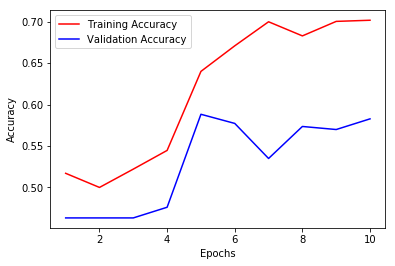

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = sentiment_model.history['acc']
val_acc = sentiment_model.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color = 'red', label='Training acc')
plt.plot(epochs, val_acc, color = 'blue', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.figure()

In [14]:
y_predict = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_predict ]


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
print(conf_mat)

true_pos = np.diag(conf_mat) 
precision = true_pos / np.sum(conf_mat, axis=0)
recall = true_pos / np.sum(conf_mat, axis=1)
mean_recall = np.mean(recall)
mean_precision = np.mean(precision)
mean_f1 = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
print(mean_recall)
print(mean_precision)
print(mean_f1)

[[ 38  88]
 [ 26 120]]
0.5617525549032398
0.5853365384615384
0.5733021050605066


In [15]:
new_review = nlp("Need to be more aggressive in exploring newer avenues")

new_review_sentiment_terms = []
new_review_sentiment_terms.append(' '.join([token.lemma_ for token in new_review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))

print(new_review_sentiment_terms)
#vectorizing the tweet by the pre-fitted tokenizer instance
review = tokenizer.texts_to_sequences(new_review_sentiment_terms)
#padding the tweet to have exactly the same shape as `embedding_2` input
review = pad_sequences(review, maxlen=30, dtype='int32', value=0)
#print(review)
sentiment = model.predict(review,batch_size=1,verbose = 2)[0]
print(sentiment)
score = np.max(sentiment)
print(score)
position = np.argmax(sentiment)
if position == 0 and score > 0.55:
    print('negative')
elif position == 1 and score > 0.55:
    print('positive')
elif position == 0 or position == 1 and score >= 0.45 and score <=0.55:
    print('neutral')

['need aggressive explore new']
[0.0791458  0.95102704]
0.95102704
positive
